# 0.0 Imports

In [106]:
import pandas as pd
import numpy  as np

import re
import random
import pickle
import requests
import datetime
import inflection

import seaborn   as sns
import umap.umap_as umap

from sklearn import preprocessing as pp
from sklearn import cluster as c
from sklearn import metrics as m 

from matplotlib           import pyplot as plt
from IPython.core.display import HTML
from matplotlib.gridspec  import GridSpec

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

c:\Users\Gabriel\anaconda3\envs\customer_identification\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper functions

In [2]:
def rename_columns(dataframe):
    df = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    #cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.set_option('max_columns', None, "max_rows", 50)
    pd.options.display.max_rows = 999
    pd.set_option( 'display.expand_frame_repr', False )
    pd.options.mode.copy_on_write = True
    
    sns.set()

In [3]:
jupyter_settings()

## 0.2 Loading data

In [4]:
df_raw = pd.read_excel('../data/raw/Online Retail.xlsx')

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 1.0 Data description

In [6]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [7]:
# Using the function we created in section 0.1
df1 = rename_columns(df1)

## 1.2 Data dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


## 1.3 Data types

In [9]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Drop NA 

In [11]:
df1 = df1.dropna( subset=['description', 'customer_id'] )
print( 'Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25


In [12]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change types

In [45]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

# invoice number
df1['invoice_no'] = df1['invoice_no'].astype(str)

# stock code
df1['stock_code'] = df1['stock_code'].astype(str)

In [40]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.7. Descriptive Statistics

In [41]:
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical attribuites

In [42]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


1. Quantity negativa
2. Unit price zero

### 1.7.2. Categorical Attributes

In [43]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search("[^0-9]+",x))), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 8905
Total number of negative quantity: 8905


Stock code

In [46]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

Description

In [47]:
df1.head()

# Acão: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


Country

In [50]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: country, dtype: float64

In [51]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False).head()

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


# 2.0 Feature filtering

In [52]:
df2 = df1.copy()

In [53]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0 Feature engineering

In [65]:
df3 = df2.copy()

In [66]:
cols_drop = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country']

df_ref = df3.drop(cols_drop, axis=1).drop_duplicates(ignore_index=True)

In [67]:
# Gross Revenue
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

In [68]:
# Recency - Last day purchase
# **inverter função**
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2_purchases['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
#df_recency['recency_days'] = df_recency['recency_days'].apply( lambda x: 1 / x if x != 0 else 0)
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [69]:
# Frequency
df_freq = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [70]:
# Avg Ticket
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

# 4.0 EDA - Análise exploratória dos dados

In [71]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

In [26]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40,0,< 1 Year,1,25455.0,152,203,0
216539,216540,Female,26,1,8,1,< 1 Year,0,38393.0,26,45,0
78983,78984,Female,32,1,28,0,< 1 Year,1,32118.0,122,35,1
218368,218369,Male,32,1,37,0,< 1 Year,1,37711.0,152,215,0
307215,307216,Female,24,1,28,0,< 1 Year,1,48706.0,156,222,0


## 4.1 Análise univariada

### 4.1.1 Response variable

### 4.1.2 Numerical variable

### 4.1.3 Categorical variable

## 4.2 Análise bivariada

### 4.2.x Hipothesis validation

### 4.2.y Hipothesis resume

## 4.3 Análise multivariada

### 4.3.1 Numerical attributes

### 4.3.2 Categorical attributes

# 5.0 Data Preparation

In [77]:
df5 = df4.copy()

## 5.1 Normalization

In [78]:
## Standard Scalaer
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )

In [271]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40,0,< 1 Year,1,-0.297943,152,203,0
216539,216540,Female,26,1,8,1,< 1 Year,0,0.452554,26,45,0
78983,78984,Female,32,1,28,0,< 1 Year,1,0.088559,122,35,1
218368,218369,Male,32,1,37,0,< 1 Year,1,0.412993,152,215,0
307215,307216,Female,24,1,28,0,< 1 Year,1,1.050781,156,222,0


# 6.0 Feature selection

In [79]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [83]:
X = df6.drop( columns=['customer_id'] )

In [84]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.377179,2.786689,3.889207,-0.033935
1,0.135378,-0.355762,0.620902,-0.033423
2,0.524388,-0.894468,1.405296,-0.026618
3,-0.120506,0.033303,0.097974,-0.023240
4,-0.128600,2.407600,-0.163491,0.152447


In [85]:
clusters = np.arange(2, 10, 1)

## 7.1 Within-Cluster Sum of Square (WSS)

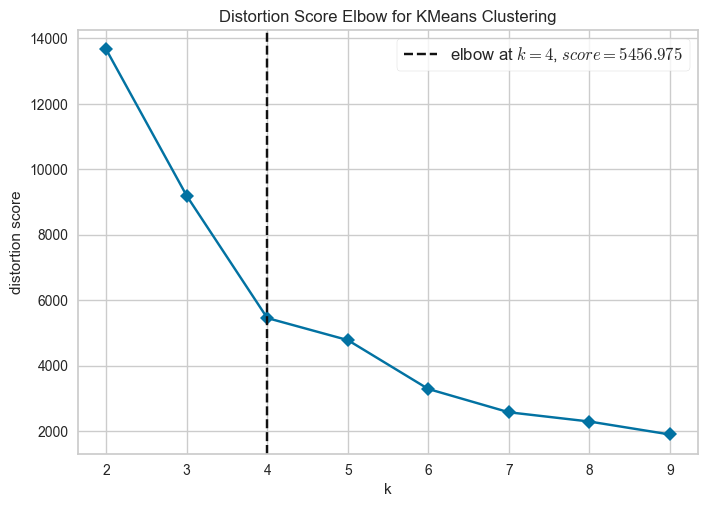

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [92]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 Silhouette Score

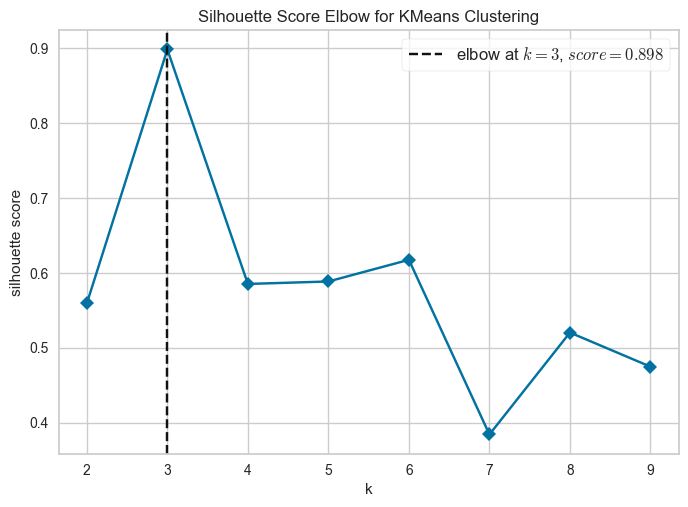

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [93]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

## 7.3 Silhouette Analysis

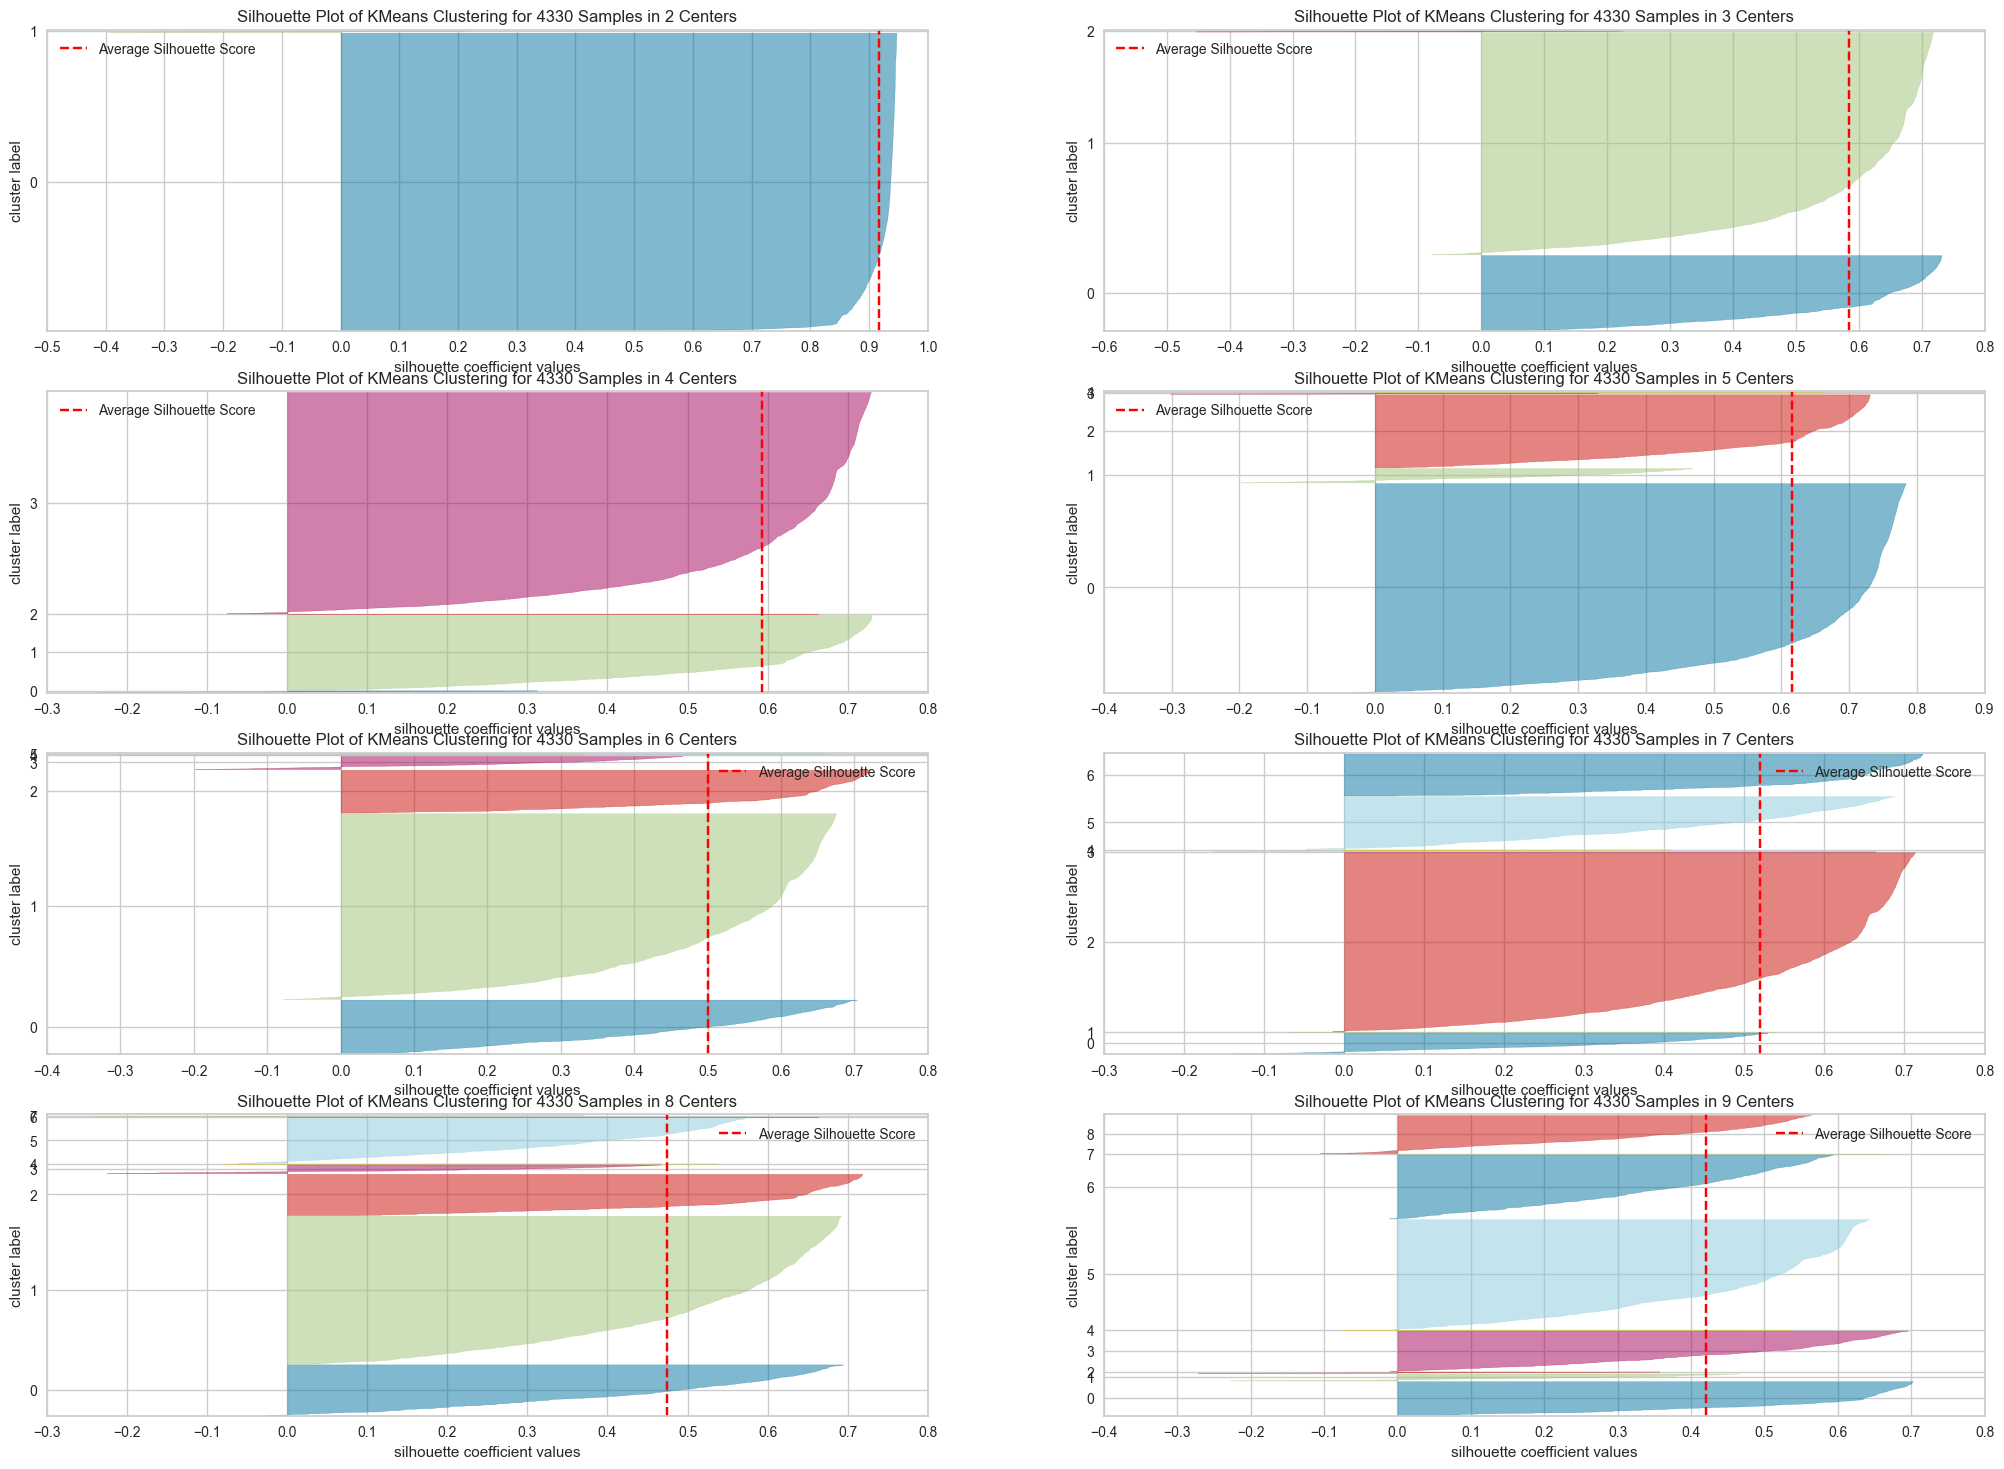

In [94]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 8.0 Model training

## 8.1 K-Means

In [99]:
# Model definition
k = 5 
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, random_state=42, max_iter=300 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

### 8.1.1 Cluster validation

In [100]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 4146.804210177519
SS value: 0.6155969838172496


# 9.0 Cluster analysis

In [102]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.377179,2.786689,3.889207,-0.033935,1
1,13047,0.135378,-0.355762,0.620902,-0.033423,0
2,12583,0.524388,-0.894468,1.405296,-0.026618,1
3,13748,-0.120506,0.033303,0.097974,-0.023240,0
4,15100,-0.128600,2.407600,-0.163491,0.152447,2


c:\Users\Gabriel\anaconda3\envs\customer_identification\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


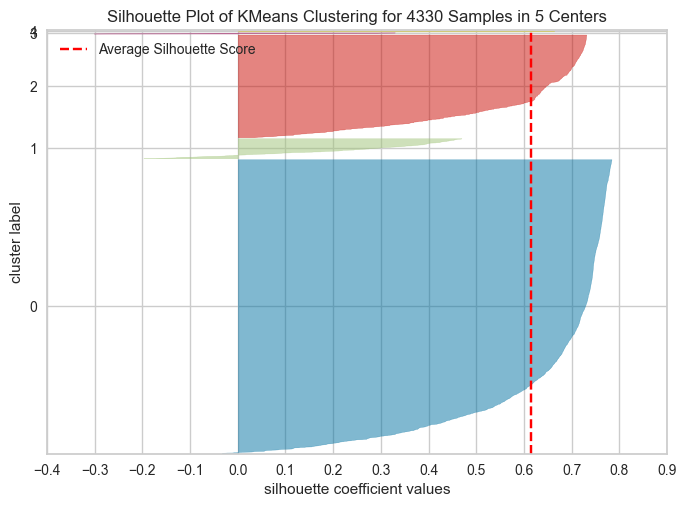

In [103]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

## 9.2. 2d plot

In [108]:
df_viz = df9.drop( columns='customer_id', axis=1 )
#sns.pairplot( df_viz, hue='cluster' )

## 9.3. UMAP

c:\Users\Gabriel\anaconda3\envs\customer_identification\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

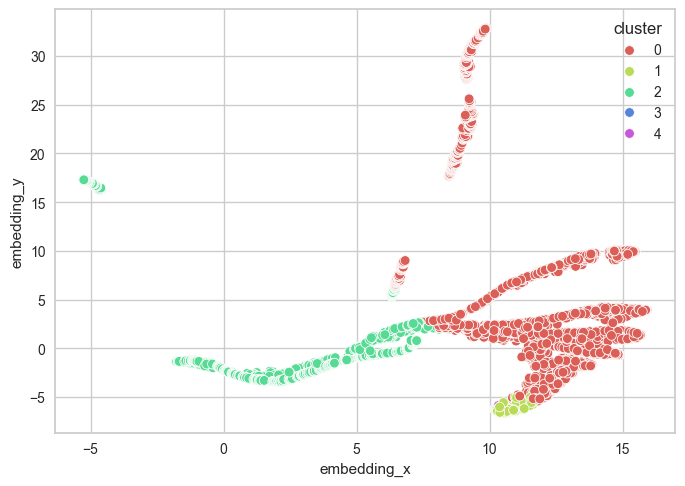

In [113]:
reducer = umap.UMAP( n_neighbors=90, random_state=41 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2 Cluster profile

In [114]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,3043,70.277136,-0.077530,-0.488171,-0.079286,-0.026487
1,1,208,4.803695,1.112384,-0.785403,2.339905,0.047978
2,2,1065,24.595843,-0.173472,1.556433,-0.354004,-0.019614
3,3,12,0.277136,13.519256,-0.845419,11.025006,0.070872
4,4,2,0.046189,13.532067,0.706686,-0.359589,45.329979


# 10.0 Deploy